In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math
import pmdarima as pm

import lead_lag as ll

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,13.845620,69.033740,47.262580,48.004780,55.496120,11.740700,18.177200,46.78280,68.537300,50.185100,...,31.651400,63.251640,12.502360,60.843540,36.523580,52.461460,57.537160,34.427360,41.273040,56.123620
std,0.748745,3.908187,0.614438,2.051494,1.733916,0.635884,0.299771,1.26656,0.585843,3.207362,...,0.771223,7.833634,0.940225,1.898022,1.561982,0.756214,4.548284,0.878169,3.814908,1.178059
min,12.630000,62.470000,46.330000,44.900000,51.660000,10.020000,17.650000,44.01000,67.260000,45.260000,...,30.270000,50.620000,10.630000,56.260000,31.760000,50.210000,49.200000,32.800000,31.640000,53.470000
25%,13.207500,65.517500,46.820000,45.750000,54.000000,11.480000,17.970000,45.91750,68.110000,47.597500,...,30.950000,55.865000,11.817500,59.420000,35.837500,52.050000,54.062500,33.800000,39.615000,55.317500
50%,13.590000,68.255000,46.975000,47.830000,55.880000,11.850000,18.100000,46.69000,68.550000,49.535000,...,31.590000,64.615000,12.210000,60.750000,36.825000,52.375000,55.425000,34.350000,41.665000,56.100000
75%,14.582500,72.915000,47.800000,50.380000,56.720000,12.210000,18.410000,47.50250,68.912500,52.192500,...,32.302500,70.352500,13.232500,62.107500,37.602500,52.892500,61.855000,35.032500,43.525000,57.002500
max,15.560000,75.150000,48.610000,51.010000,59.120000,13.000000,18.980000,51.09000,69.990000,59.100000,...,33.260000,77.470000,14.500000,66.090000,39.130000,54.150000,66.600000,36.480000,50.020000,59.310000


In [3]:
# Check if stationary
# Non-stationary
def test_stationary(series):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationary(df[8])

Results of Dickey-Fuller Test:
Test Statistic                  -2.613868
p-value                          0.090165
#Lags Used                       2.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64
Results of KPSS Test:
Test Statistic            0.665248
p-value                   0.016705
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [4]:
from datetime import datetime, timedelta

train = df.iloc[:300, :]
train.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(train.shape[0])]
mvgTrain = train[:].rolling(5).mean()

test = df.iloc[300:, :]
test.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(test.shape[0])]
mvgTest = test[:].rolling(5).mean()

0.9069515239547417
0.9166891332053609


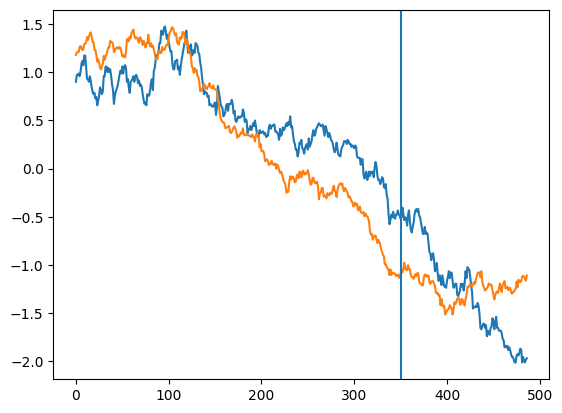

In [ ]:
# Check for lead lags
# (18, 3): Not accurate enough
share1 = 18
share2 = 3
lag = 13

standard1 = (df[share1] - df[share1].mean())/ df[share1].std()
standard2 = (df[share2] - df[share2].mean())/ df[share2].std()
shifted1 = pd.Series(np.array(standard1)[:-lag])
shifted2 = pd.Series(np.array(standard2)[lag:])

print(shifted1.corr(shifted2))
print(df[share1].corr(df[share2]))

sns.lineplot(shifted1)
sns.lineplot(shifted2)
plt.axvline(350)


<Axes: ylabel='18'>

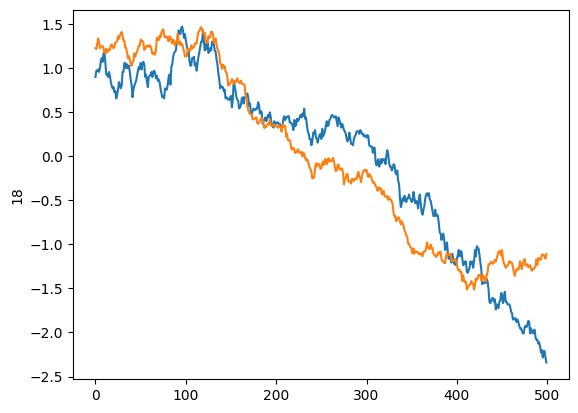

In [ ]:
sns.lineplot(standard1)
sns.lineplot(standard2)

In [ ]:
print(df[8])
print(df[8].shift(2).dropna().values)
print(df[8])

0      69.49
1      69.73
2      69.60
3      69.54
4      69.68
       ...  
495    69.00
496    69.04
497    68.95
498    69.03
499    69.06
Name: 8, Length: 500, dtype: float64
[69.49 69.73 69.6  69.54 69.68 69.81 69.76 69.76 69.64 69.53 69.41 69.37
 69.38 69.19 69.09 69.06 68.94 68.88 68.73 68.55 68.54 68.69 68.78 68.75
 68.77 68.78 68.88 68.93 68.73 68.64 68.72 68.85 68.97 68.9  68.9  68.9
 68.92 68.88 68.73 68.69 68.77 68.82 68.75 68.64 68.56 68.6  68.62 68.54
 68.72 68.51 68.62 68.68 68.85 68.91 68.9  68.85 68.81 68.74 68.68 68.69
 68.71 68.78 68.9  68.86 68.73 68.76 68.64 68.7  68.64 68.49 68.42 68.38
 68.33 68.29 68.33 68.32 68.25 68.19 68.22 68.19 68.21 68.11 67.97 67.91
 68.03 68.2  68.31 68.2  68.28 68.26 68.33 68.15 68.24 68.23 68.18 68.15
 68.06 68.13 67.95 67.88 67.69 67.51 67.5  67.54 67.44 67.3  67.33 67.52
 67.59 67.82 67.88 67.9  68.1  68.11 68.07 68.03 68.19 68.12 68.1  68.14
 68.23 68.35 68.32 68.39 68.47 68.43 68.46 68.48 68.31 68.24 68.28 68.25
 68.32 68.39 68.52

In [5]:
results = {}
for i in range(50):
    for j in range(i+1, 50):
        t1, t2 = str(i), str(j)
        lag = ll.lag(mvgTrain[t1], mvgTrain[t2], max_lag=50)
        lag = int(lag)
        # test for cointegration
        if lag > 0:
            # t1 leads t2, shift t1 forward

            pass
        elif lag < 0:
            # other way
            t1, t2 = t2, t1
            lag = -lag
        else:
            continue

        shiftt1 = train[t1][lag:]
        shiftt2 = train[t2][:-lag]
        res = sm.tsa.stattools.coint(shiftt1, shiftt2)
        corr = shiftt1.corr(shiftt2)
        results[t1,t2] = (res[1], corr, lag)


KeyError: '0'

In [ ]:
# Predict function for lead lag
def predict_next(df, ticker, indices, lags, shift, currentPoint):
    matchedSeries = df[indices].pct_change().dropna().values
    if len(indices) > 1:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1, :]
    else:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1]
    
    predictSeries = df[ticker].pct_change().dropna().values[currentPoint-199:currentPoint+1]
    # print(matchedSeries.shape)
    # print(len(predictSeries))

    result = ardl.ARDL(
        predictSeries,
        0,
        matchedSeries,
        lags,
        causal=True
    ).fit()

    predict_val = result.forecast()
    # print(predict_mu)
    return predict_val

In [ ]:
ardl.ardl_select_order

In [10]:
# Predict function for lead lag with moving average
def predict_next_mvg(df, ticker, indices, lags, shift, currentPoint):
    matchedSeries = df[indices].rolling(5).mean().dropna().values
    if len(indices) > 1:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1, :]
    else:
        matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1]
    
    predictSeries = df[ticker].rolling(5).mean().dropna().values[currentPoint-199:currentPoint+1]
    # print(matchedSeries.shape)
    # print(len(predictSeries))

    result = ardl.ARDL(
        predictSeries,
        0,
        matchedSeries,
        lags,
        causal=True
    ).fit()

    predict_val = result.forecast()
    # print(predict_mu)
    return predict_val

0.978355400789085


<Axes: ylabel='8'>

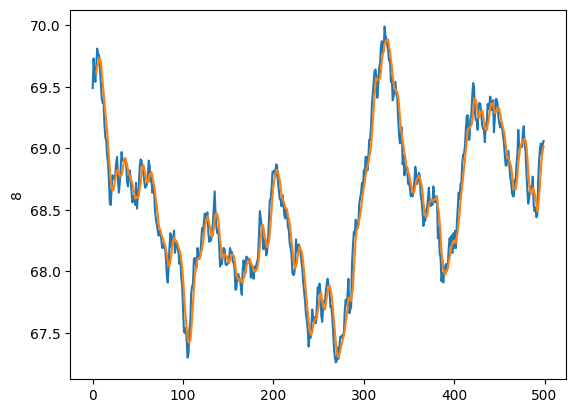

In [12]:
mvg = df[8].rolling(5).mean()
print(df[8].corr(mvg))

sns.lineplot(df[8])
sns.lineplot(mvg)

13.202558333333334 0.5575984112376791
0.004177297940428529 0.03211106002730743
-0.007025000000000007 0.016137465179723146
MSE error 0.02951871049040733


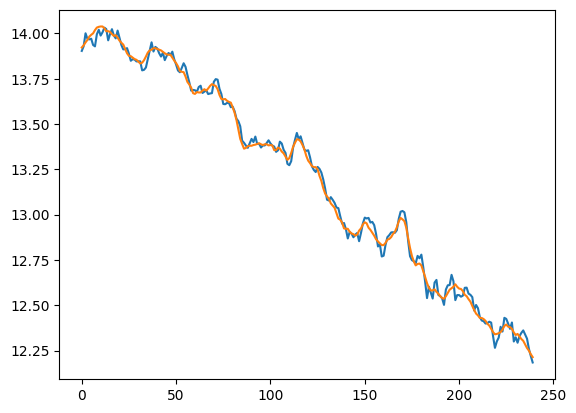

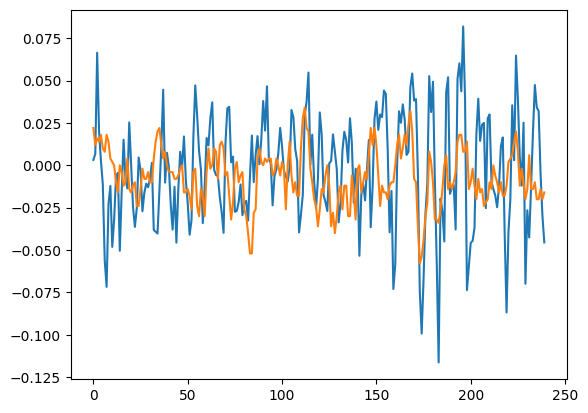

In [ ]:
predictValues = []
errors = []
actuals = []

actual_changes = []
predict_changes = []

sharePredict = 18
indices = list(range(50))
shift = 0
lags = 1
for i in range(250, 490):
    predict = predict_next_mvg(df, sharePredict, indices, lags, shift, i)[-1]
    actual_values = df[sharePredict].rolling(5).mean().dropna().values
    actual = actual_values[i+1]
    error = predict - actual

    errors.append(error)
    actuals.append(actual)
    predictValues.append(predict)
    actual_changes.append(actual - actual_values[i])
    predict_changes.append(predict - actual_values[i])

actuals = pd.Series(actuals)
errors = pd.Series(errors)
actual_changes = pd.Series(actual_changes)
print(actuals.mean(), actuals.std())
print(errors.mean(), errors.std())
print(actual_changes.mean(), actual_changes.std())
print("MSE error", math.sqrt((error * error).mean()))


sns.lineplot(predictValues)
sns.lineplot(actuals)

plt.figure()
plt.plot(predict_changes)
plt.plot(actual_changes)

In [ ]:
# For against everything, 1 lag, no shift
# 2: Not working, 8: Not working, 16: Def not working, 24: Not working, 39: Not working
# [(2, 0.0008783679163561521),
#  (8, 0.0017500270793173196),
#  (16, 0.0011701015232360602),
#  (24, 0.0019864401170313598),
#  (27, 0.0005106109910669505),
#  (38, 0.001134912126812814),
#  (39, 0.0009030856195662571)]

[(2, 0.0008783679163561521),
 (8, 0.0017500270793173196),
 (16, 0.0011701015232360602),
 (24, 0.0019864401170313598),
 (27, 0.0005106109910669505),
 (38, 0.001134912126812814),
 (39, 0.0009030856195662571)]

In [ ]:
print(len(df[8]))
print(len(df[8].pct_change()))
print(len(df.values))

500
500
500
